# Table of Contents
1. [Modules](#Modules)
2. [Experiments](#Experiments)
    1. [Data](#Data)
    2. [Überwachte_Klassifikationsverfahren](#Überwachte_Klassifikationsverfahren)
    3. [Balance_imbalanced_Data](#Balance_imbalanced_Data)
3. [Results](#Results)

# Modules

In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn import preprocessing
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.utils import resample
from mpl_toolkits.mplot3d import Axes3D;
%matplotlib inline

# Experiments

## Data

In [2]:
# lade Daten
training = pd.read_csv("./data/train.csv", delimiter="|")
features = training.drop("fraud", axis=1)
labels = training["fraud"]
# teile Daten in Test- und Trainingsdaten auf 
x_train, x_test, y_train, y_test = train_test_split(features, labels , test_size=0.2, random_state=42)

In [3]:
features.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111


In [4]:
c = Counter(training["fraud"])
anteil_frauds = int(round(c[1] / c[0],2) * 100)
print("{}% von allen Datenobjekten sind 'frauds'.".format(anteil_frauds))

6% von allen Datenobjekten sind 'frauds'.


#### Schlussfolgerung

Die Traningsdaten sind tatsächlich "imbalanced". Insbesodere hätte ein naives Klassifikationsverfahren somit eine "Accuracy" von 6%. Das Gütemaß "Accuracy" steigt mit der Anzahl der TN (= True Negative: korrekte Klassifikation als "non-fraud"). Da ich von den TN sehr viele Datenobjekte habe und mich eher die TP (= True Positive: korrekte Klassifikation als "fraud") interessieren, verwende ich im Folgenden die Gütemaße "Recall" und "Precision" in Form vom "F1-Score".  

In [5]:
means = pd.DataFrame(zip(training[training.fraud == 1].mean(), training[training.fraud == 0].mean()), index=training.columns).T
means = means.append(( means.iloc[0,:] / means.iloc[1,:] ) - 1, ignore_index=True)
means.index = ["fraud", "non-fraud", "diff %"]
means

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
fraud,1.144231,1173.913462,51.034327,6.375000,5.865385,2.519231,0.031582,0.053622,0.251412,1.0
non-fraud,3.534085,917.988169,50.854541,5.416901,4.847887,2.525634,0.059693,0.210424,0.774348,0.0
diff %,-0.676230,0.278789,0.003535,0.176872,0.209885,-0.002535,-0.470922,-0.745171,-0.675325,inf


#### Schlussfolgerung

The customer's "trustLevel" (whatever this is) seems to be a strong indicator for a potential fraud. Additionally frauds seem to scan items more slowly and they seem to buy many cheap items instead of a few expensive ones.

#### Visualisation via PCA

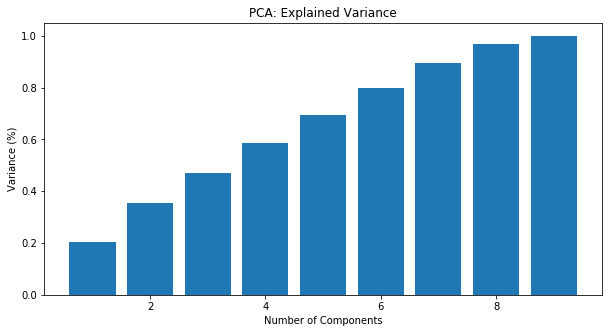

In [6]:
scaler = StandardScaler(copy=True, with_mean=True, with_std=True);
features_std = scaler.fit_transform(features);
features_std = pd.DataFrame(features_std, columns=features.columns);
pca = PCA().fit(features_std)

plt.figure(figsize=(10,5))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1, 1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') 
plt.title('PCA: Explained Variance')
plt.show()
plt.close()

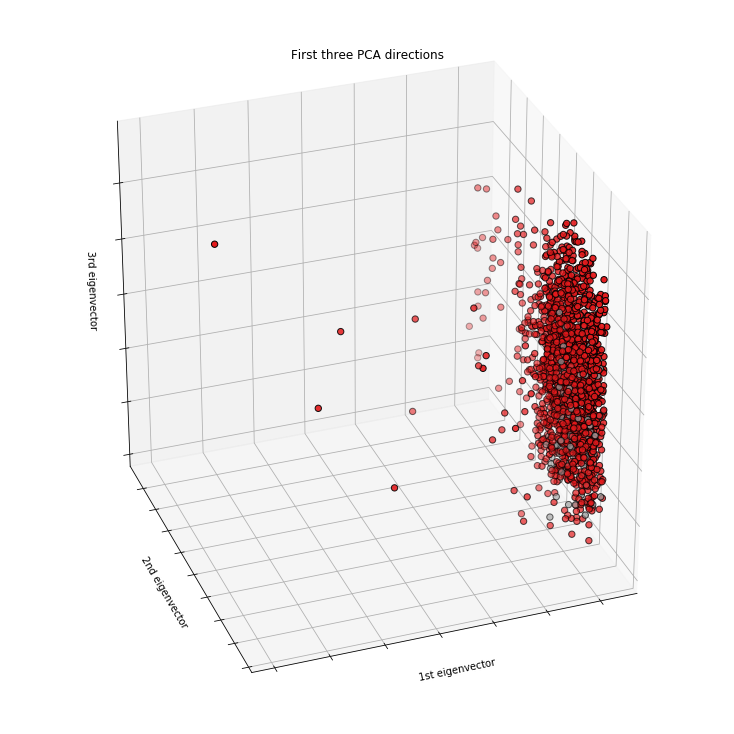

In [7]:
fig = plt.figure(figsize=(10, 10));
ax = Axes3D(fig, elev=-150, azim=110);
features_std_pca3 = PCA(n_components=3).fit_transform(features_std);
ax.scatter(features_std_pca3[:, 0], features_std_pca3[:, 1], features_std_pca3[:, 2], c=training["fraud"], cmap=plt.cm.Set1, edgecolor='k', s=40);
ax.set_title("First three PCA directions");
ax.set_xlabel("1st eigenvector");
ax.w_xaxis.set_ticklabels([]);
ax.set_ylabel("2nd eigenvector");
ax.w_yaxis.set_ticklabels([]);
ax.set_zlabel("3rd eigenvector");
ax.w_zaxis.set_ticklabels([]);

#### Schlussfolgerung

Entweder die "fraud" Datenobjekte sind den anderen Datenobjekten sehr ähnlich oder die ersten drei "principal components" sind nicht aussagekräftig genug. Die Tatsache, dass die ersten drei "principal components" lediglich ca. 50% der Varianz erklären, spricht für Letzteres.  

## Überwachte_Klassifikationsverfahren

#### Naive Classifier

In [8]:
# Entscheidungsmodell 
y_pred = [0 for i in range(0, len(y_test))]

# Güte bestimmen
precision = round(precision_score(y_test, y_pred), 3) if any(y_pred) else 0
recall = round(recall_score(y_test, y_pred), 3) if any(y_pred) else 0
f1 = round(f1_score(y_test, y_pred), 3) if precision + recall != 0 else 0
accuracy = round(accuracy_score(y_test, y_pred), 3)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-Score: ", f1)
print("Accuracy: ", accuracy)

Precision:  0
Recall:  0
F1-Score:  0
Accuracy:  0.963


#### Random Forest

In [9]:
# Entscheidungsmodell
rfc = RandomForestClassifier(n_estimators = 1000)
rfc.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [10]:
# Güte bestimmen
y_pred = rfc.predict(x_test)
precision = round(precision_score(y_test, y_pred), 3) if any(y_pred) else 0
recall = round(recall_score(y_test, y_pred), 3) if any(y_pred) else 0
f1 = round(f1_score(y_test, y_pred), 3) if any(y_pred) else 0
accuracy = round(accuracy_score(y_test, y_pred), 3)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-Score: ", f1)
print("Accuracy: ", accuracy)

Precision:  0.583
Recall:  0.5
F1-Score:  0.538
Accuracy:  0.968


#### Random Forest (with Principal Components)

In [11]:
# Merkmalausprägungen standardisieren (da PCA Varianz maximiert)
scaler = StandardScaler(copy=True, with_mean=True, with_std=True);
x_train_std = scaler.fit_transform(x_train);
x_train_std = pd.DataFrame(x_train_std, columns=x_train.columns);
x_train_std.index = x_train.index

In [12]:
# Anzahl von Principal Components bestimmen
minExplainedVariance = 0.9
pca = PCA().fit(x_train_std)
optimalNumberOfClusters = 0
for i in np.cumsum(pca.explained_variance_ratio_):
    optimalNumberOfClusters = optimalNumberOfClusters + 1
    if i > minExplainedVariance:
        break;

print("Die {} ersten PCA-Komponenten erklären mehr als {}% der Varianz.".format(optimalNumberOfClusters, int(minExplainedVariance*100)))

Die 7 ersten PCA-Komponenten erklären mehr als 90% der Varianz.


In [13]:
# PCA Transformierung durchführen
pca = PCA(n_components=optimalNumberOfClusters);
x_train_std_pca = pca.fit_transform(x_train_std);
x_train_std_pca = pd.DataFrame(x_train_std_pca);
x_train_std_pca.index = x_train_std.index

In [14]:
# Entscheidungsmodell trainieren
rfc = RandomForestClassifier(n_estimators = 100)
rfc.fit(x_train_std_pca, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [15]:
# Merkmalausprägungen von Testdaten standardisieren 
scaler = StandardScaler(copy=True, with_mean=True, with_std=True);
x_test_std = scaler.fit_transform(x_test);
x_test_std = pd.DataFrame(x_test_std);
x_test_std.index = x_test.index

# PCA Transformierung von Testdaten durchführen 
pca = PCA(n_components=optimalNumberOfClusters);
x_test_std_pca = pca.fit_transform(x_test_std);
x_test_std_pca = pd.DataFrame(x_test_std_pca);
x_test_std_pca.index = x_test_std.index

# Güte bestimmen
y_pred = rfc.predict(x_test_std_pca)
precision = round(precision_score(y_test, y_pred), 3) if any(y_pred) else 0
recall = round(recall_score(y_test, y_pred), 3)  if any(y_pred) else 0
f1 = round(f1_score(y_test, y_pred), 3) if any(y_pred) else 0
accuracy = round(accuracy_score(y_test, y_pred), 3)

print("Precision: ", precision)
print("Recall: ", recall)
print("F1-Score: ", f1)
print("Accuracy: ", accuracy)

Precision:  0.0
Recall:  0.0
F1-Score:  0.0
Accuracy:  0.939


#### Schlussfolgerung

Random Forest ohne PCA funktioniert am Besten. 

## Balance_imbalanced_Data

In [16]:
# Upsampling: dupliziere zufällig fraud Datenobjekte, damit die Mengen der frauds und non-frauds gleich groß sind.
not_fraud = x_train[y_train == 0]
fraud = x_train[y_train == 1]

fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

x_train_upsampled = pd.concat([not_fraud, fraud_upsampled])

y_train_fraud = pd.Series(data=[1 for i in range(0,len(fraud_upsampled))], index=fraud_upsampled.index)
y_train_nonfraud = pd.Series(data=[0 for i in range(0,len(not_fraud))], index=not_fraud.index)
y_train_upsampled = pd.concat([y_train_nonfraud, y_train_fraud])

In [17]:
# Entscheidungsmodell
rfc = RandomForestClassifier(n_estimators = 1000)
rfc.fit(x_train_upsampled, y_train_upsampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [18]:
# Güte bestimmen
y_pred = rfc.predict(x_test)
precision = round(precision_score(y_test, y_pred), 3) if any(y_pred) else 0
recall = round(recall_score(y_test, y_pred), 3) if any(y_pred) else 0
f1 = round(f1_score(y_test, y_pred), 3) if any(y_pred) else 0
accuracy = round(accuracy_score(y_test, y_pred), 3)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-Score: ", f1)
print("Accuracy: ", accuracy)

Precision:  0.562
Recall:  0.643
F1-Score:  0.6
Accuracy:  0.968


#### Schlussfolgerung

Upsampling führt zu einer Verbesserung des F1-Scores bei Verwendung des RandomForest Klassifizierers. 

# Results

In [24]:
# Load Trainings Data
training = pd.read_csv("./data/train.csv", delimiter="|")
features = training.drop("fraud", axis=1)
labels = training["fraud"]

# Upsample fraud data
not_fraud = features[labels == 0]
fraud = features[labels == 1]

fraud_upsampled = resample(fraud,
                          replace=True, 
                          n_samples=len(not_fraud), 
                          random_state=12) 

features_upsampled = pd.concat([not_fraud, fraud_upsampled])

labels_fraud = pd.Series(data=[1 for i in range(0,len(fraud_upsampled))], index=fraud_upsampled.index)
labels_nonfraud = pd.Series(data=[0 for i in range(0,len(not_fraud))], index=not_fraud.index)
labels_upsampled = pd.concat([labels_nonfraud, labels_fraud])

# Train Model: Random Forest Classifier 
rfc = RandomForestClassifier(n_estimators = 1000)
rfc.fit(features_upsampled, labels_upsampled)

# Predict
test = pd.read_csv("./data/test.csv", delimiter="|")
pred = rfc.predict(test)

# Save prediction to file
s = pd.Series(pred, name="fraud")
s.to_csv(index=False, encoding="ASCII", sep="|", header=True, path_or_buf='./data/magnus_goedde_prediction.csv')